# Decode against a 1s preodor baseline period, within a trial type (to see if trial-type decoding is being driven by changes in CS+ representation, CS-, or both)

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_dhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within_beta', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'sig_vs_chance', ignoring

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
all_animals =      'dhpcg1','dhpcg20','dhpc24'
pre_animals =      'dhpcg1','dhpcg20','dhpc24'
d2_animals =       'dhpcg1','dhpcg20','dhpc24'
post_animals =     'dhpcg1','dhpcg20','dhpc24'
pre_rev_animals =  'dhpcg1','dhpcg20','dhpc24'
post_rev_animals = 'dhpcg1','dhpcg20','dhpc24'
catch_animals =    'dhpcg1','dhpcg20'

In [8]:
sessions = 'pre','d2','post','pre_rev','post_rev','catch'

all_labels='rwVSsh','rwVScsm','shVScsm','rwndVSshnd','rwVSrwnd','rwndVScsm','shVSshnd','shndVScsm'
non_catch_labels = 'rwVSsh','rwVScsm','shVScsm'
catch_labels = 'rwndVSshnd','rwVSrwnd','rwndVScsm','shVSshnd','shndVScsm'

In [9]:
for sess in sessions:
    for dur in 1,: #use 5 for 0.5sec, 1 for 1 sec and 2 for 2sec
        exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb_%s_%s',\
                                                           '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,dur,sess))
        exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,sess))
#        if sess == 'catch':
#            exec("labels_catch_nd = dict(zip(%s_animals, [ut.load_variable('labels_%s_nd',\
#                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
#                                                  for ani in %s_animals]))"%(sess,sess,sess))

In [10]:
#delta_t0 = 1sec
#from referenced notebook, 14 time bins total beginning at 3s prior to odor onset and running through 11s post onset

#t_start0 = -3  # sec
#t_stop0 = 11  # sec

In [11]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)
    #scores = decoder.score(xT, yT)
    #decoder.fit(xT, yT)
    #return np.append(scores,decoder.score(x, y))
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

In [12]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [13]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [14]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [15]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [16]:
for sess in sessions:
    for t in range(13):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 pre dhpcg1 pre dhpcg20 pre dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 d2 dhpcg1 d2 dhpcg20 d2 dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dhpcg1 post dhpcg20 post dhpc24 post dh

In [17]:
relabel_nd = {0:0,1:1,2:2,-1:6,-2:7}

for sess in 'catch',:
    exec("labels_%s_nd = {}"%(sess))
    for ani in eval("%s_animals"%sess):
        exec("labels_%s_nd[ani] = np.r_[[relabel_nd[l] for l in labels_%s[ani]]]"%(sess,sess))
exec("labels_%s = labels_%s_nd.copy()"%(sess,sess))

### need to take data from a single trial type and duplicate it, assigning it a new label/class. Then use the baseline time bin of the dataset with this new label and decode against all time bins from original dataset

In [18]:
#make a new label array, assigning new labels for each trial type
relabel_baselines = {0:3,1:4,2:5,-1:-4,-2:-5}

for sess in sessions[:-1]:
    exec("labels_baselines_%s = {}"%sess)
    for ani in eval("%s_animals"%sess):
        exec("labels_baselines_%s[ani] = np.r_[[relabel_baselines[l] for l in labels_%s[ani]]]"%(sess,sess))

In [19]:
#make a new label array specifically for catch session, assigning new labels for each trial type
relabel_baselines = {0:3,1:4,2:5,6:8,7:9}

for sess in 'catch',:
    exec("labels_baselines_%s = {}"%sess)
    for ani in eval("%s_animals"%sess):
        exec("labels_baselines_%s[ani] = np.r_[[relabel_baselines[l] for l in labels_%s[ani]]]"%(sess,sess))

In [20]:
#concatenate new label array to original
for sess in sessions:
    exec("labels_%s_w_baselines = {}"%sess)
    for ani in eval("labels_%s.keys()"%sess):
        exec("labels_%s_w_baselines[ani] = np.concatenate((labels_%s[ani],labels_baselines_%s[ani]))"%(sess,sess,sess))

In [21]:
# concatenate patterns from one time bin with itself
base = 0 # time bin that will be used as baseline (0 = -3 to -2)
for sess in sessions:
    for t in range(13):
        exec("patterns_tb_%s_%s_w_baselines = {}"%(t,sess))
        for ani in eval("patterns_tb_%s_%s.keys()"%(t,sess)):
            exec("patterns_tb_%s_%s_w_baselines[ani] = np.concatenate((patterns_tb_%s_%s[ani],patterns_tb_%s_%s[ani]))"%(t,sess,t,sess,base,sess))

#### now decode using both labels from a single trial type, reserving one label for the baseline time bin, and the other label for all time bins

In [22]:
n_cells_within_min_overall = ut.load_variable('n_cells_within_min_overall','../notebooks/autorestore/n_cells/')
n_cells = n_cells_within_min_overall

In [66]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:0,1:-1,2:-1,3:1,4:-1,5:-1}
n_loops=20
for t in range(13): # number of time bins
    exec('baseline_scores_tb_%s_csm = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_csm"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,6), n_cells=n_cells, relabel=relabel) for i in range(n_loops)]]

post 0 post 1 post 2 post 3 post 4 post 5 post 6 post 7 post 8 post 9 post 10 post 11 post 12CPU times: user 8.3 s, sys: 32 ms, total: 8.33 s
Wall time: 8.31 s



In [67]:
print np.mean(baseline_scores_tb_4_csm['post'][-loops:])
print np.std(baseline_scores_tb_4_csm['post'][-loops:])

0.831
0.0674091981854


In [12]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:-1,1:1,2:-1,3:-1,4:0,5:-1}
n_loops=20
for t in range(13): # number of time bins
    exec('baseline_scores_tb_%s_rw = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_rw"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,6), n_cells=n_cells, relabel=relabel) for i in range(n_loops)]]

post 0 post 1 post 2 post 3 post 4 post 5 post 6 post 7 post 8 post 9 post 10 post 11 post 12CPU times: user 19.9 s, sys: 100 ms, total: 20 s
Wall time: 20 s



In [13]:
baseline_scores_tb_4_rw['post'][-10:].mean()

0.97449999999999992

In [14]:
np.std(baseline_scores_tb_4_rw['post'][-10:])

0.02392174742781137

In [26]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:-1,1:-1,2:0,3:-1,4:-1,5:1}
n_loops=20
for t in range(13): # number of time bins
    exec('baseline_scores_tb_%s_sh = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_sh"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,6), n_cells=n_cells, relabel=relabel) for i in range(n_loops)]]

pre 0 d2 0 post 0 pre_rev 0 post_rev 0 catch 0 pre 1 d2 1 post 1 pre_rev 1 post_rev 1 catch 1 pre 2 d2 2 post 2 pre_rev 2 post_rev 2 catch 2 pre 3 d2 3 post 3 pre_rev 3 post_rev 3 catch 3 pre 4 d2 4 post 4 pre_rev 4 post_rev 4 catch 4 pre 5 d2 5 post 5 pre_rev 5 post_rev 5 catch 5 pre 6 d2 6 post 6 pre_rev 6 post_rev 6 catch 6 pre 7 d2 7 post 7 pre_rev 7 post_rev 7 catch 7 pre 8 d2 8 post 8 pre_rev 8 post_rev 8 catch 8 pre 9 d2 9 post 9 pre_rev 9 post_rev 9 catch 9 pre 10 d2 10 post 10 pre_rev 10 post_rev 10 catch 10 pre 11 d2 11 post 11 pre_rev 11 post_rev 11 catch 11 pre 12 d2 12 post 12 pre_rev 12 post_rev 12 catch 12CPU times: user 1min 32s, sys: 6.21 s, total: 1min 38s
Wall time: 1min 38s



In [38]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:-1,1:-1,2:-1,3:-1,4:-1,5:-1,6:0,7:-1,8:1,9:-1}
n_loops=20
for t in range(13): # number of time bins
    exec('baseline_scores_tb_%s_rwnd = {}'%t)
    for sess in 'catch',:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_rwnd"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,10), n_cells=n_cells, relabel=relabel) for i in range(n_loops)]]

catch 0 catch 1 catch 2 catch 3 catch 4 catch 5 catch 6 catch 7 catch 8 catch 9 catch 10 catch 11 catch 12CPU times: user 15 s, sys: 20 ms, total: 15 s
Wall time: 15 s



In [28]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {0:-1,1:-1,2:-1,3:-1,4:-1,5:-1,6:-1,7:0,8:-1,9:1}
n_loops=20
for t in range(13): # number of time bins
    exec('baseline_scores_tb_%s_shnd = {}'%t)
    for sess in 'catch',:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_shnd"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(0,10), n_cells=n_cells, relabel=relabel) for i in range(n_loops)]]

catch 0 catch 1 catch 2 catch 3 catch 4 catch 5 catch 6 catch 7 catch 8 catch 9 catch 10 catch 11 catch 12CPU times: user 14.8 s, sys: 20 ms, total: 14.8 s
Wall time: 14.8 s



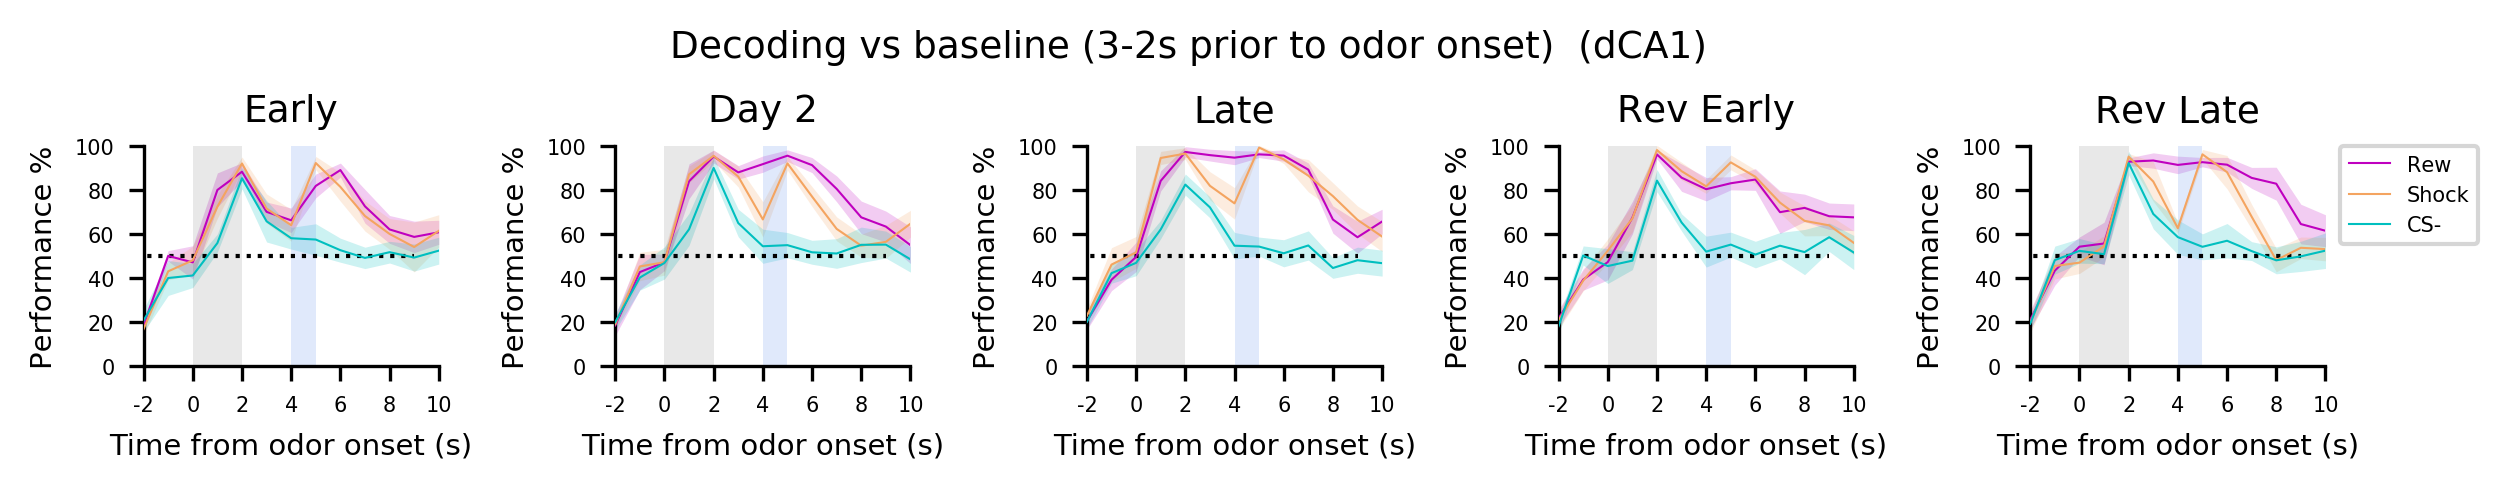

In [54]:
fig, ax = pl.subplots(1,5, figsize=(8, 1.5))
loops=10
for comp,c,la in zip(['rw','sh','csm'],['m','sandybrown','c'],['Rew','Shock','CS-']):
    for r,sess in zip(range(len(sessions[:-1])),sessions[:-1]):
        ax[r].plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s[sess][-loops:]"%(t,comp)))*100) for t in range(13)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s[sess][-loops:]"%(t,comp)))*100) for t in range(13)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s[sess][-loops:]"%(t,comp)))*100 for t in range(13)])
        ax[r].fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range(len(sessions[:-1])):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
    pt.plot_period_bar(ax[x], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Early', fontsize=9, color = 'k')
ax[1].set_title('Day 2', fontsize=9, color='k')
ax[2].set_title('Late', fontsize=9, color = 'k')
ax[3].set_title('Rev Early', fontsize=9, color = 'k')
ax[4].set_title('Rev Late', fontsize=9, color = 'k')
#ax[5].set_title('Rev w/ Catch', fontsize=9, color='k')
ax[4].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (3-2s prior to odor onset)  (dCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

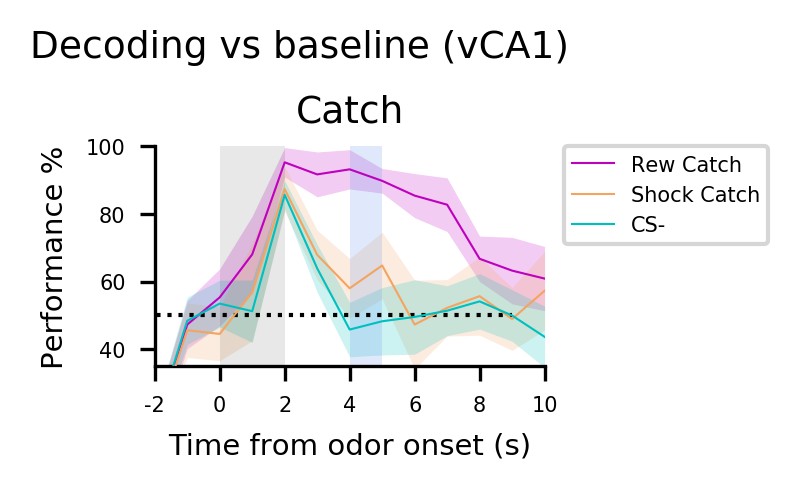

In [30]:
fig, ax = pl.subplots(figsize=(2, 1.5))

for comp,c,la in zip(['rwnd','shnd','csm'],['m','sandybrown','c'],['Rew Catch','Shock Catch','CS-']):
    for r,sess in zip([1],['catch']):
        ax.plot([(t-2) for t in range(13)], [(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(13)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(13)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(13)])
        ax.fill_between([(t-2) for t in range(13)],m-s,m+s,alpha=0.2,color=c,linewidth=0)

ax.set_ylim(35, 100)
ax.set_xlim(-2, 9)
ax.set_xticks(np.arange(-2,11, 2))
ax.set_xticklabels(np.arange(-2,11, 2))
ax.hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
pt.plot_period_bar(ax, 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax.set_title('Catch', fontsize=9, color = 'k')

#ax[5].set_title('Rev w/ Catch', fontsize=9, color='k')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (CA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

In [68]:
save_workspace(db)

Could not store variable 'pickle'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'np'. Skipping...
